In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer

import warnings
#warnings.filterwarnings("ignore")

In [2]:
oscar_movies = pd.read_csv("./oscar_movies.csv")
oscar_movies.head()

,Title,producers,winner,year,Actors,Awards,Country,Director,Genre,Language,...,Year,imdbID,imdbRating,imdbVotes,BAFTA,NBRA,GOLDENGLOBE,SATELLITE,DGA,tag
0,Wings,['Paramount Famous Lasky'],True,1927,"Clara Bow, Charles 'Buddy' Rogers, Richard Arl...",Won 2 Oscars. Another 3 wins & 1 nomination.,USA,"William A. Wellman, Harry d'Abbadie d'Arrast","Drama, Romance, War, Action",English,...,1927,tt0018578,7.7,"9,884",False,False,False,False,False,none
1,The Racket,['The Caddo Company'],False,1927,"Robert Mitchum, Lizabeth Scott, Robert Ryan, W...",NaN,USA,"John Cromwell, Mel Ferrer, Tay Garnett, Nichol...","Crime, Drama, Film-Noir",English,...,1951,tt0043955,6.8,"2,056",False,False,False,False,False,none
2,7th Heaven,['Fox'],False,1927,"Stephen Collins, Catherine Hicks, Beverley Mit...",Nominated for 1 Primetime Emmy. Another 20 win...,USA,NaN,"Drama, Family, Romance",English,...,1996–2007,tt0115083,5.2,"22,707",False,False,False,False,False,none
3,The Broadway Melody,['Metro-Goldwyn-Mayer'],True,1928,"Charles King, Anita Page, Bessie Love",Won 1 Oscar. Another 2 nominations.,USA,Harry Beaumont,"Drama, Musical, Romance",English,...,1929,tt0019729,6.2,"5,601",False,False,False,False,False,none
4,Alibi,['Feature Productions'],False,1928,"Achmed Akkabi, Georgina Verbaan, Frederik Brom...",1 win.,Netherlands,Johan Nijenhuis,Comedy,Dutch,...,2008,tt0827170,5.7,796,False,False,False,False,False,none


In [3]:
binarizer = MultiLabelBinarizer()
genres = pd.DataFrame(
    binarizer.fit_transform(oscar_movies["Genre"].astype(str).str.split(",")),
    columns=binarizer.classes_
)
binarizer = MultiLabelBinarizer()
tags = pd.DataFrame(
    binarizer.fit_transform(oscar_movies["tag"].astype(str).str.split(",")),
    columns=binarizer.classes_
)

In [4]:
movies_dummy_genres = pd.concat([oscar_movies, genres], axis=1)
movies_dummy_genres = pd.concat([movies_dummy_genres, tags], axis=1)

191    0.900036
111    0.900036
11     0.900036
21     0.900036
31     0.900036
dtype: float64

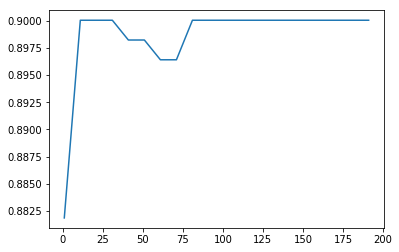

In [5]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE"]
y = movies_dummy_genres["winner"]
X_dict = movies_dummy_genres[features].to_dict(orient="records")
def get_F1(k):
    vec = DictVectorizer(sparse=False)
    scaler = StandardScaler()
    model = RandomForestClassifier(n_estimators=k, 
                                max_depth=15, 
                              min_samples_leaf=10)
    #model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    return cross_val_score(pipeline,X_dict,  y, 
                cv=10, scoring="accuracy").mean()
  
    
ks = pd.Series(range(1, 200, 10))
ks.index = range(1, 200, 10)
test_errs = ks.apply(get_F1)

test_errs.plot.line()
test_errs.sort_values(ascending=False).head()

Using the data from all the other years, we will now attempt to predict what movie won the best oscar for a particular year. 

In [6]:
year = 2013
train_df = movies_dummy_genres[movies_dummy_genres["year"] != year]
test_df = movies_dummy_genres[movies_dummy_genres["year"] == year]
def randomForest():
    X_train_dict = train_df[features].to_dict(orient="records")
    X_new_dict = test_df[features].to_dict(orient="records")
    y_train = train_df["winner"]
    
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_new = vec.transform(X_new_dict)

    # Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_new_sc = scaler.transform(X_new)

    # machine learning model
    model = RandomForestClassifier(n_estimators=191, 
                                  max_depth=15, 
                                  min_samples_leaf=10, 
                                  oob_score=True)
    #model = KNeighborsClassifier(n_neighbors=11)
    model.fit(X_train_sc, y_train)
    
    return model.predict(X_new_sc)
randomForest()

array([False, False, False, False,  True, False, False, False, False], dtype=bool)